In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
from copy import deepcopy
from PIL import Image
import pytesseract as tess
tess.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'

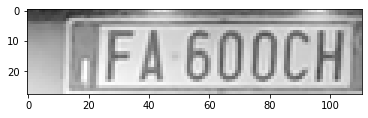

In [2]:
img=  cv2.imread('Plate No. 1.png')
# img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
gray_img = cv2.imread('Plate No. 1.png',0)
plt.imshow(gray_img,cmap="gray", vmin=0, vmax=255)

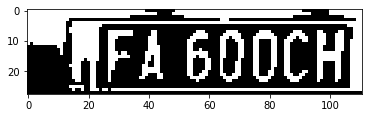

In [3]:
### Converting to Binary form
ret, thresh = cv2.threshold(gray_img,150,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(thresh,cmap="gray", vmin=0, vmax=255)

In [34]:
def preprocess(img):
#     imgBlurred = cv2.GaussianBlur(img, (5,5), 0)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    ret2,threshold_img = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    plt.subplot(2,2,1),plt.imshow(threshold_img,cmap="gray", vmin=0, vmax=255)
    return threshold_img


In [53]:
def cleanPlate(plate):
	print("CLEANING PLATE. . .")
	gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
	kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
	thresh= cv2.dilate(gray, kernel, iterations=1)

	_, thresh = cv2.threshold(thresh, 150, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
	contours,hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

	if contours:
		areas = [cv2.contourArea(c) for c in contours]
		max_index = np.argmax(areas)

		max_cnt = contours[max_index]
		max_cntArea = areas[max_index]
		x,y,w,h = cv2.boundingRect(max_cnt)

		if not ratioCheck(max_cntArea,w,h):
			return plate,None

		cleaned_final = thresh[y:y+h, x:x+w]
		#cv2.imshow("Function Test",cleaned_final)
		return cleaned_final,[x,y,w,h]

	else:
		return plate,None

In [54]:
def ratioCheck(area, width, height):
	ratio = float(width) / float(height)
	if ratio < 1:
		ratio = 1 / ratio

	aspect = 4.7272
	min = 15*aspect*15  # minimum area
	max = 125*aspect*125  # maximum area

	rmin = 3
	rmax = 6

	if (area < min or area > max) or (ratio < rmin or ratio > rmax):
		return False
	return True

def isMaxWhite(plate):
	avg = np.mean(plate)
	if(avg>=115):
		return True
	else:
 		return False

def validateRotationAndRatio(rect):
	(x, y), (width, height), rect_angle = rect

	if(width>height):
		angle = -rect_angle
	else:
		angle = 90 + rect_angle

	if angle>15:
	 	return False

	if height == 0 or width == 0:
		return False

	area = height*width
	if not ratioCheck(area,width,height):
		return False
	else:
		return True

In [55]:
def extract_contours(threshold_img):
    
    element = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(17, 3))
    morph_img_threshold = threshold_img.copy()
    cv2.morphologyEx(src=threshold_img, op=cv2.MORPH_CLOSE, kernel=element, dst=morph_img_threshold)
    
    plt.subplot(2,2,2),plt.imshow(morph_img_threshold,cmap="gray", vmin=0, vmax=255)


    contours, hierarchy= cv2.findContours(threshold_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    return contours

In [56]:

def cleanAndRead(img,contours):
    for i,cnt in enumerate(contours):
        min_rect = cv2.minAreaRect(cnt)

        if validateRotationAndRatio(min_rect):

            x,y,w,h = cv2.boundingRect(cnt)
            plate_img = img[y:y+h,x:x+w]


            if(isMaxWhite(plate_img)):
                clean_plate, rect = cleanPlate(plate_img)
                
                if rect:
                    x1,y1,w1,h1 = rect
                    x,y,w,h = x+x1,y+y1,w1,h1
                    plt.subplot(2,2,3), plt.imshow(clean_plate, cmap='gray')
                    plate_im = Image.fromarray(clean_plate)
                    text = tess.image_to_string(plate_im, lang='eng')
                    print("Detected Text : ",text)


	#print "No. of final cont : " , count

CLEANING PLATE. . .


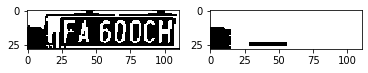

In [57]:
img=  cv2.imread('Plate No. 1.png')
threshold_img = preprocess(img)
contours= extract_contours(threshold_img)
cleanAndRead(img,contours)